In [16]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tqdm import tqdm 
from tensorflow.keras import *

In [17]:



train_token_path = "./data/imdb/train_token.csv"
test_token_path = "./data/imdb/test_token.csv"

MAX_WORDS = 10000  # We will only consider the top 10,000 words in the dataset
MAX_LEN = 200  # We will cut reviews after 200 words
BATCH_SIZE = 20 

# 构建管道
def parse_line(line):
    t = tf.strings.split(line,"\t")
    label = tf.reshape(tf.cast(tf.strings.to_number(t[0]),tf.int32),(-1,))
    features = tf.cast(tf.strings.to_number(tf.strings.split(t[1]," ")),tf.int32)
    return (features,label)

ds_train=  tf.data.TextLineDataset(filenames = [train_token_path]) \
   .map(parse_line,num_parallel_calls = tf.data.experimental.AUTOTUNE) \
   .shuffle(buffer_size = 1000).batch(BATCH_SIZE) \
   .prefetch(tf.data.experimental.AUTOTUNE)

ds_test=  tf.data.TextLineDataset(filenames = [test_token_path]) \
   .map(parse_line,num_parallel_calls = tf.data.experimental.AUTOTUNE) \
   .shuffle(buffer_size = 1000).batch(BATCH_SIZE) \
   .prefetch(tf.data.experimental.AUTOTUNE)

In [18]:
tf.keras.backend.clear_session()

model = models.Sequential()

model.add(layers.Embedding(MAX_WORDS,7,input_length=MAX_LEN))
model.add(layers.Conv1D(filters = 64,kernel_size = 5,activation = "relu"))
model.add(layers.MaxPool1D(2))
model.add(layers.Conv1D(filters = 32,kernel_size = 3,activation = "relu"))
model.add(layers.MaxPool1D(2))
model.add(layers.Flatten())
model.add(layers.Dense(1,activation = "sigmoid"))

model.compile(optimizer='Nadam',
            loss='binary_crossentropy',
            metrics=['accuracy',"AUC"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 7)            70000     
_________________________________________________________________
conv1d (Conv1D)              (None, 196, 64)           2304      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 32)            6176      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 48, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [21]:
import datetime
baselogger = callbacks.BaseLogger(stateful_metrics=["AUC"])
logdir = "./data/keras_model/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [20]:
tensorboard_callback

In [24]:
history = model.fit(ds_train,validation_data = ds_test,
        epochs = 6)

Epoch 1/6
1000/1000 [==============================] - 7s 7ms/step - loss: 0.1078 - accuracy: 0.9609 - auc: 0.9924 - val_loss: 0.4809 - val_accuracy: 0.8558 - val_auc: 0.9295
Epoch 2/6
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0658 - accuracy: 0.9771 - auc: 0.9968 - val_loss: 0.5912 - val_accuracy: 0.8566 - val_auc: 0.9210
Epoch 3/6
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0370 - accuracy: 0.9873 - auc: 0.9988 - val_loss: 0.7547 - val_accuracy: 0.8522 - val_auc: 0.9136
Epoch 4/6
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0235 - accuracy: 0.9920 - auc: 0.9995 - val_loss: 0.9272 - val_accuracy: 0.8512 - val_auc: 0.9057
Epoch 5/6
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0185 - accuracy: 0.9938 - auc: 0.9997 - val_loss: 1.0859 - val_accuracy: 0.8436 - val_auc: 0.8964
Epoch 6/6
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0127 - accuracy: 0.9959 - auc: 0.9998 - val_loss

In [25]:
history = model.fit(ds_train,validation_data = ds_test,
        epochs = 6,callbacks=[tensorboard_callback])

Epoch 1/6
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0128 - accuracy: 0.9954 - auc: 0.9999 - val_loss: 1.2452 - val_accuracy: 0.8500 - val_auc: 0.8932
Epoch 2/6
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0126 - accuracy: 0.9958 - auc: 0.9998 - val_loss: 1.2975 - val_accuracy: 0.8534 - val_auc: 0.8914
Epoch 3/6
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0106 - accuracy: 0.9961 - auc: 0.9999 - val_loss: 1.3125 - val_accuracy: 0.8526 - val_auc: 0.8920
Epoch 4/6
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0116 - accuracy: 0.9958 - auc: 0.9996 - val_loss: 1.3959 - val_accuracy: 0.8556 - val_auc: 0.8927
Epoch 5/6
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0103 - accuracy: 0.9958 - auc: 0.9999 - val_loss: 1.6308 - val_accuracy: 0.8392 - val_auc: 0.8830
Epoch 6/6
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0064 - accuracy: 0.9980 - auc: 0.9999 - val_loss

In [26]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

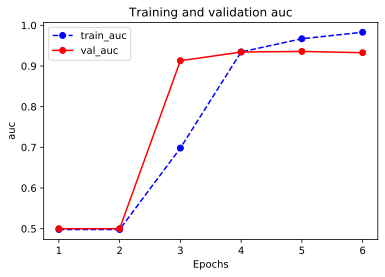

In [33]:
plot_metric(history,"auc")

In [28]:
tf.keras.backend.clear_session()

inputs = layers.Input(shape=[MAX_LEN])
x  = layers.Embedding(MAX_WORDS,7)(inputs)

branch1 = layers.SeparableConv1D(64,3,activation="relu")(x)
branch1 = layers.MaxPool1D(3)(branch1)
branch1 = layers.SeparableConv1D(32,3,activation="relu")(branch1)
branch1 = layers.GlobalMaxPool1D()(branch1)

branch2 = layers.SeparableConv1D(64,5,activation="relu")(x)
branch2 = layers.MaxPool1D(5)(branch2)
branch2 = layers.SeparableConv1D(32,5,activation="relu")(branch2)
branch2 = layers.GlobalMaxPool1D()(branch2)

branch3 = layers.SeparableConv1D(64,7,activation="relu")(x)
branch3 = layers.MaxPool1D(7)(branch3)
branch3 = layers.SeparableConv1D(32,7,activation="relu")(branch3)
branch3 = layers.GlobalMaxPool1D()(branch3)

concat = layers.Concatenate()([branch1,branch2,branch3])
outputs = layers.Dense(1,activation = "sigmoid")(concat)

model = models.Model(inputs = inputs,outputs = outputs)

model.compile(optimizer='Nadam',
            loss='binary_crossentropy',
            metrics=['accuracy',"AUC"])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 7)       70000       input_1[0][0]                    
__________________________________________________________________________________________________
separable_conv1d (SeparableConv (None, 198, 64)      533         embedding[0][0]                  
__________________________________________________________________________________________________
separable_conv1d_2 (SeparableCo (None, 196, 64)      547         embedding[0][0]                  
______________________________________________________________________________________________

In [29]:
import datetime
logdir = "./models/keras_model/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
history = model.fit(ds_train,validation_data = ds_test,epochs = 6,callbacks=[tensorboard_callback])

Epoch 1/6
1000/1000 [==============================] - 11s 11ms/step - loss: 0.6932 - accuracy: 0.4963 - auc: 0.4979 - val_loss: 0.6934 - val_accuracy: 0.4876 - val_auc: 0.5000
Epoch 2/6
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6932 - accuracy: 0.4988 - auc: 0.4979 - val_loss: 0.6934 - val_accuracy: 0.4876 - val_auc: 0.5000
Epoch 3/6
1000/1000 [==============================] - 11s 11ms/step - loss: 0.6013 - accuracy: 0.6187 - auc: 0.6982 - val_loss: 0.3781 - val_accuracy: 0.8298 - val_auc: 0.9130
Epoch 4/6
1000/1000 [==============================] - 11s 11ms/step - loss: 0.3271 - accuracy: 0.8608 - auc: 0.9345 - val_loss: 0.3325 - val_accuracy: 0.8566 - val_auc: 0.9343
Epoch 5/6
1000/1000 [==============================] - 12s 12ms/step - loss: 0.2327 - accuracy: 0.9079 - auc: 0.9670 - val_loss: 0.3477 - val_accuracy: 0.8606 - val_auc: 0.9358
Epoch 6/6
1000/1000 [==============================] - 12s 12ms/step - loss: 0.1646 - accuracy: 0.9416 - auc: 0.982

In [31]:
history.history

{'loss': [0.6932061314582825,
  0.6931697726249695,
  0.6012807488441467,
  0.32709357142448425,
  0.23273569345474243,
  0.1645699292421341],
 'accuracy': [0.4962500035762787,
  0.49880000948905945,
  0.6187499761581421,
  0.8608499765396118,
  0.9078500270843506,
  0.9416000247001648],
 'auc': [0.4979398846626282,
  0.49786096811294556,
  0.6981561779975891,
  0.9345301985740662,
  0.9669714570045471,
  0.9829268455505371],
 'val_loss': [0.693378210067749,
  0.6934060454368591,
  0.37806400656700134,
  0.33248648047447205,
  0.34774723649024963,
  0.3953602910041809],
 'val_accuracy': [0.4875999987125397,
  0.4875999987125397,
  0.829800009727478,
  0.8565999865531921,
  0.8605999946594238,
  0.8528000116348267],
 'val_auc': [0.5,
  0.5,
  0.9130252599716187,
  0.9343082308769226,
  0.9357702732086182,
  0.9326417446136475]}

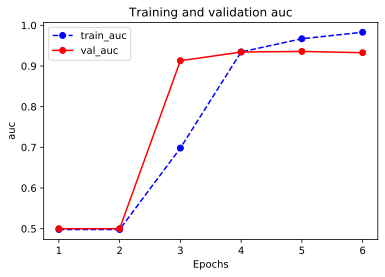

In [32]:
plot_metric(history,"auc")

In [34]:
# 先自定义一个残差模块，为自定义Layer

class ResBlock(layers.Layer):
    def __init__(self, kernel_size, **kwargs):
        super(ResBlock, self).__init__(**kwargs)
        self.kernel_size = kernel_size
    
    def build(self,input_shape):
        self.conv1 = layers.Conv1D(filters=64,kernel_size=self.kernel_size,
                                   activation = "relu",padding="same")
        self.conv2 = layers.Conv1D(filters=32,kernel_size=self.kernel_size,
                                   activation = "relu",padding="same")
        self.conv3 = layers.Conv1D(filters=input_shape[-1],
                                   kernel_size=self.kernel_size,activation = "relu",padding="same")
        self.maxpool = layers.MaxPool1D(2)
        super(ResBlock,self).build(input_shape) # 相当于设置self.built = True
    
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.conv3(x)
        x = layers.Add()([inputs,x])
        x = self.maxpool(x)
        return x
    
    #如果要让自定义的Layer通过Functional API 组合成模型时可以序列化，需要自定义get_config方法。
    def get_config(self):  
        config = super(ResBlock, self).get_config()
        config.update({'kernel_size': self.kernel_size})
        return config

In [ ]:
# 测试ResBlock
resblock = ResBlock(kernel_size = 3)
resblock.build(input_shape = (None,200,7))
resblock.compute_output_shape(input_shape=(None,200,7))

In [ ]:
# 自定义模型，实际上也可以使用Sequential或者FunctionalAPI

class ImdbModel(models.Model):
    def __init__(self):
        super(ImdbModel, self).__init__()
        
    def build(self,input_shape):
        self.embedding = layers.Embedding(MAX_WORDS,7)
        self.block1 = ResBlock(7)
        self.block2 = ResBlock(5)
        self.dense = layers.Dense(1,activation = "sigmoid")
        super(ImdbModel,self).build(input_shape)
    
    def call(self, x):
        x = self.embedding(x)
        x = self.block1(x)
        x = self.block2(x)
        x = layers.Flatten()(x)
        x = self.dense(x)
        return(x)

In [ ]:
tf.keras.backend.clear_session()

model = ImdbModel()
model.build(input_shape =(None,200))
model.summary()

model.compile(optimizer='Nadam',
            loss='binary_crossentropy',
            metrics=['accuracy',"AUC"])

In [ ]:
import datetime

logdir = "./tflogs/keras_model/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
history = model.fit(ds_train,validation_data = ds_test,
                    epochs = 6,callbacks=[tensorboard_callback])

In [ ]:
plot_metric(history,"AUC")